# Data Wrangling and Methods

Based on code published in Persistence of human norovirus (GII) in surface water: Decay rate constants and inactivation mechanisms. by Lauren C. Kennedy, Veronica P. Costantini, Kimberly A. Huynh, Stephanie K. Loeb, Wiley C. Jennings, Sarah Lowry, Mia C. Mattioli, Jan Vinjé, Alexandria B. Boehm. Environmental Science and Technology (2023)

code DOI: https://doi.org/10.25740/tr061rz9792
paper DOI: https://doi.org/10.1021/acs.est.2c09637

Note that kobs_import are k values directly imported from that paper for comparison

## 1. Load R packages

In [1]:
# data wrangling/exploration
library(googledrive)
library(readr)
library(tidyr)
library(GGally)
library(googlesheets4)
library(stringr)
# library(pcr) #modified the source code instead

# plotting
library(ggplot2)
library(viridis)
library(ggpubr)
library(ggrepel)   #for text labels on plots

#tables
library(dplyr)
library(stargazer)

#cite
library(knitr)

#modeling
library(broom)

options(jupyter.plot_mimetypes = c("text/plain","image/png"))

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘googlesheets4’


The following objects are masked from ‘package:googledrive’:

    request_generate, request_make


Loading required package: viridisLite


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




### Modified PCR package code

In [2]:
#source code from the pcr package for R because I wanted to modify how they calculate R2 to allow NaNs https://github.com/cran/pcr/blob/master/R/analyses_fun.R
.pcr_rsquared <- function(vec, var) {
  ll <- lm(vec ~ log10(var))
  res <-summary(ll)$r.squared 
    # res <- cor(vec, log10(var))^2
  return(res)
}


.pcr_intercept <- function(vec, var) {
  ll <- lm(vec ~ log10(var))
  res <- coefficients(ll)
  return(res[[1]])
}


.pcr_slope <- function(vec, var) {
  ll <- lm(vec ~ log10(var))
  res <- coefficients(ll)
  return(res[[2]])
}

pcr_standard <- function(df, amount, plot = FALSE) {
  # order data.frame and group var
  df <- df[order(amount),]
  amount <- amount[order(amount)]

  # return data when plot is false
  if (plot) {
    gg <- .pcr_plot_assess(df,
                           amount,
                           method = 'standard_curve')

    return(gg)
  } else {
    # calculate trend; intercept, slope and r_squared
    trend <- apply(df,
                   MARGIN = 2,
                   FUN = function(x) {
                     data.frame(
                       gene = '',
                       intercept = .pcr_intercept(x, amount),
                       slope = .pcr_slope(x, amount),
                       r_squared = .pcr_rsquared(x, amount),
                       num_points = sum(!is.na(x))/2,
                       max_ct = round(max(x,na.rm=T),2)
                     )
                   })

    # make a data.frame
    trend <- do.call(rbind, trend)
    trend$gene <- names(df)
    rownames(trend) <- NULL

    return(trend)
  }
}

pcr_assess <- function(df, method = 'standard_curve', ...) {
  switch(method,
         'standard_curve' = pcr_standard(df, ...),
         'efficiency' = pcr_efficiency(df, ...))
}

col_names_all<-c("plate_id", "intercept","slope","r_sq", "num_pts", "max_ct","efficiency")

In [3]:
#my wrapper for qPCR std curve results

std_assess<- function(dfo){
    targs<- unique(dfo$target)
    df_curve_fin<- data.frame()

    for(targ in targs){
        df<-dfo[dfo$target== targ,]
        reg<-unique(df$target_region)
        df<-df[,c("plate_id","quantity", "CT","target")]
        df$num_lab<- +(!duplicated(df[,c("plate_id","quantity")]))
        df$num_lab<-df$num_lab +1
        df$num_lab2<- +(!duplicated(df[,c("plate_id","quantity","num_lab")]))
        df$label<- paste(as.character(df$quantity),as.character(df$num_lab),as.character(df$num_lab2)) #because some are triplicate

        df_wide <- spread(df, plate_id, CT)
        df_wide = df_wide[,(names(df_wide) != "label")]
        df_wide = df_wide[,(names(df_wide) != "num_lab")]
        df_wide = df_wide[,(names(df_wide) != "num_lab2")]
        df_wide = df_wide[,(names(df_wide) != "target")]
        
        # set quantity
        quantity=df_wide$quantity
        df_curve<-pcr_assess(df_wide,amount = quantity,method = 'standard_curve')
        df_curve$efficiency<-round((10^(-1/df_curve$slope)-1)*100,2)
        names(df_curve)<-col_names_all
        df_curve$r_sq<-round(df_curve$r_sq,2)
        df_curve = df_curve[df_curve$plate_id != "quantity",]
        df_curve<-df_curve[,c("plate_id", "intercept","slope","r_sq", "num_pts","efficiency","max_ct")]
        df_curve$target<- targ
        df_curve$target_region<- reg
        df_curve_fin=rbind(df_curve_fin,df_curve)

    }
    return(df_curve_fin)
    
    }



std_assess_master<- function(dfo){
    targs<- unique(dfo$target)
    df_curve_fin<- data.frame()

    for(targ in targs){
        df<-dfo[dfo$target== targ,]
        
        # set quantity
        quantity=df$quantity
        df<-df[,c( "quantity","CT")]
        
        df_curve<-pcr_assess(df,amount = quantity,method = 'standard_curve')
        df_curve$efficiency<-round((10^(-1/df_curve$slope)-1)*100,2)
        names(df_curve)<-col_names_all
        df_curve$r_sq<-round(df_curve$r_sq,2)
        df_curve = df_curve[df_curve$plate_id != "quantity",]
        df_curve<-df_curve[,c("intercept","slope","r_sq", "num_pts","efficiency","max_ct")]
        df_curve$target<- targ
        df_curve_fin=rbind(df_curve_fin,df_curve)

    }
    return(df_curve_fin)
    
    }
    
    

In [4]:
#locations of data and figures and tables
path_f=paste(getwd(),"/Figures_and_tables/", sep="")
path_d=paste(getwd(),"/Data/", sep="")

#sizing in mm based on https://www.elsevier.com/authors/author-schemas/artwork-and-media-instructions/artwork-sizing
min_w=30
single.col_w= 90
half.col_w= 140
max_w= 190
max_h=240

## 2. Load & wrangle dataset

In [5]:
#read files
filenames <- list.files(path=path_d,pattern="*csv")

#names without extension
names <-sapply(strsplit(filenames, "\\."), `[`, 1)

# load
for(i in names){
    filepath <- file.path(path_d,paste(i,".csv",sep=""))
    assign(i, read.delim(filepath,sep = ","))
}


## 3. qPCR 

In [6]:
# Lower detection limits
qpcr_NR1_lower<- 100  #gc/rxn 
qpcr_MP1_lower<- 100  #gc/rxn 
qpcr_ORF_lower<- 5*2  #gc/rxn 

#make dataframes with LODs by assay
assay_exp5<-c("NR1","MP1","ORF")
low_gcrxn_exp5<- c(qpcr_NR1_lower,qpcr_MP1_lower,qpcr_ORF_lower)
temp_vol_exp5<-c(2,2, 5)
lod_exp5<-data.frame(assay_exp5,low_gcrxn_exp5,temp_vol_exp5)
names(lod_exp5)<-c("target","low_gc.rxn","template_volume_ul")
lod_exp5$elution_volume_ul<-60
lod_exp5$extracted_volume_ul<-200
lod_exp5$dim_conv<- (lod_exp5$elution_volume_ul * 1000)/(lod_exp5$extracted_volume_ul *lod_exp5$template_volume_ul)
lod_exp5$low_gc.ml<-lod_exp5$low_gc.rxn  * lod_exp5$dim_conv

### Individual Standard Curves

In [7]:
# subset based on LoD
expt_5_std<-left_join(expt_5_std,lod_exp5[,c("target","low_gc.rxn")])
expt_5_std<-expt_5_std[(as.numeric(expt_5_std$quantity) >= expt_5_std$low_gc.rxn),]
expt_5_std<-expt_5_std[,c("quantity","CT","plate_id","target")]
std_curves_5<- std_assess(expt_5_std)


std_curves_ORF<-std_curves_5[std_curves_5$target=="ORF",]
std_curves_SYBR<-std_curves_5[std_curves_5$target!="ORF",]
std_curves_ORF

# std_curves_SYBR
expt_5<-expt_5_std
expt_5_std<-left_join(expt_5_std,std_curves_5)

Joining, by = "target"


,plate_id,intercept,slope,r_sq,num_pts,efficiency,max_ct,target
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
22,P46,35.37851,-3.333050,1,6,99.54,29.86,ORF
32,P47,39.43783,-3.490036,1,6,93.43,33.92,ORF
42,P51,36.18411,-3.454577,1,6,94.75,30.38,ORF
52,P52,35.20457,-3.310357,1,6,100.49,29.87,ORF
62,P53,36.56217,-3.489895,1,6,93.44,30.44,ORF
72,P54,35.32096,-3.316320,1,6,100.23,29.81,ORF
8,P55,35.68542,-3.346217,1,6,99.00,29.92,ORF
9,P56,36.47811,-3.460457,1,6,94.53,30.74,ORF
10,P58,35.29407,-3.343242,1,6,99.12,29.83,ORF


Joining, by = c("plate_id", "target")


#### Figure S1

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



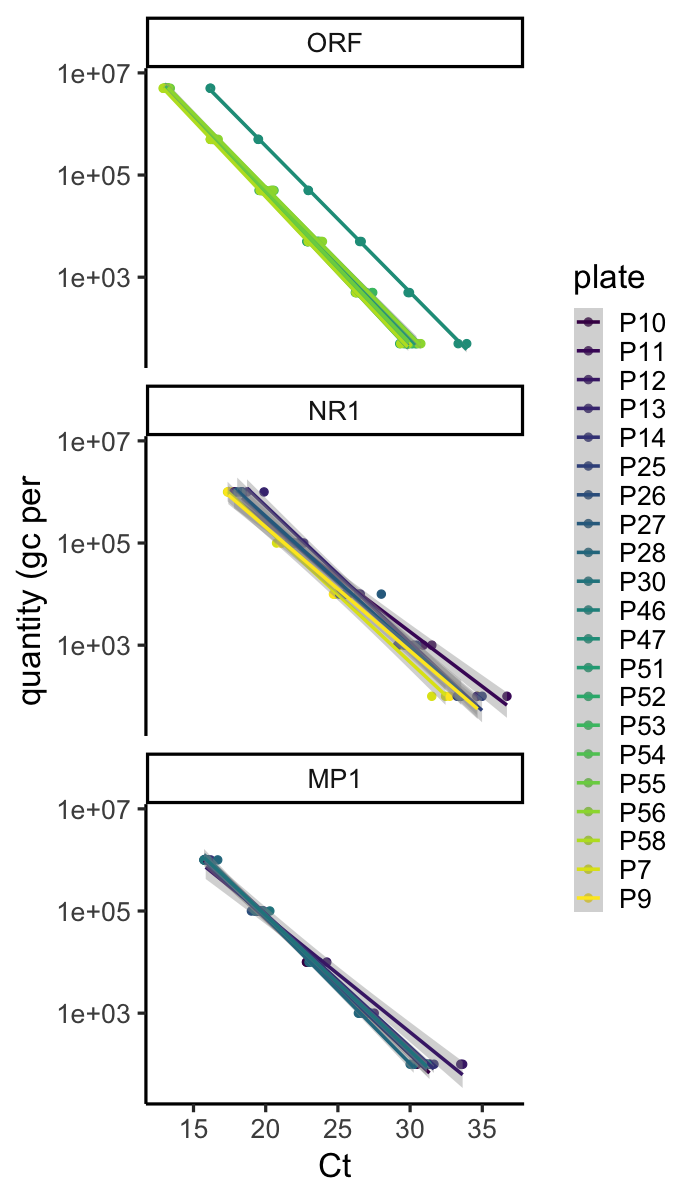

In [8]:
b=10
options(repr.plot.width =b*(half.col_w/max_h), repr.plot.height = b) #change the size of the plot
theme_set(theme_classic(base_size=20))# set font size

c<-expt_5
c$CT<- as.numeric(c$CT)
c$plate_id<- as.factor(c$plate_id)

c$target<-factor(c$target, levels=c("ORF", "NR1","MP1"))

g<- ggplot(c, aes(x=CT, y=quantity))+
    geom_point(size=2, aes(color=plate_id))+
    geom_smooth(method='lm', aes(color=plate_id))+
    xlab("Ct")+
    ylab("quantity (gc per ")+
    scale_color_viridis_d()+
    facet_wrap(~target, ncol=1)+
    labs(color="plate")+
    guides(color=guide_legend(ncol =1))+
    scale_y_log10()+
    scale_x_continuous(breaks=seq(0,35,5))+
    theme(legend.position= "right")


ggsave(paste0(path_f,"Figure_S1.jpg"),  units='mm',device= 'jpg',width=half.col_w, height=max_h)

g


### Master Standard Curves

#### Table S5

In [9]:
#  master curves
#add in curves from development

std_df_master<- expt_5

std_df_master_curves<-std_assess_master(std_df_master) #max_ct is the max of a single replicate from all replicates in master curves
# std_df_master_curves

#format for paper
c<-std_df_master_curves
c<-c[,c("target","r_sq","efficiency","slope","intercept")]
names(c)<-  c("target","R2","efficiency","slope","intercept")
c

,target,R2,efficiency,slope,intercept
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2,NR1,0.98,78.76,-3.964151,41.69627
21,MP1,0.99,82.90,-3.813720,38.68111
22,ORF,0.97,97.09,-3.393795,36.17175


In [10]:
stargazer(c,type="html", summary=FALSE, rownames=FALSE, digits=2, out=paste0(path_f,"Table_S5.doc"))


<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">target</td><td>R2</td><td>efficiency</td><td>slope</td><td>intercept</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">NR1</td><td>0.98</td><td>78.76</td><td>-3.96</td><td>41.70</td></tr>
<tr><td style="text-align:left">MP1</td><td>0.99</td><td>82.90</td><td>-3.81</td><td>38.68</td></tr>
<tr><td style="text-align:left">ORF</td><td>0.97</td><td>97.09</td><td>-3.39</td><td>36.17</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr></table>


### Convert from CT to quantity

In [11]:
#bind
expt_5_unk_ntc<- left_join(expt_5_unk_ntc,std_df_master_curves)

#sub in a value for undetermined samples
expt_5_unk_ntc$temp_lab <- "N"
expt_5_unk_ntc[expt_5_unk_ntc$CT =="Undetermined","temp_lab"]<- "Y"
expt_5_unk_ntc$CT<-as.character(expt_5_unk_ntc$CT)
expt_5_unk_ntc[expt_5_unk_ntc$CT =="Undetermined","CT"]<- "60"
expt_5_unk_ntc$CT<-as.numeric(expt_5_unk_ntc$CT)

expt_5_unk_ntc[,"quantity"]<-10^(((expt_5_unk_ntc[,"CT"])-(expt_5_unk_ntc[,"intercept"]))/expt_5_unk_ntc[,"slope"])
expt_5_unk_ntc$CT<-as.character(expt_5_unk_ntc$CT)
expt_5_unk_ntc[expt_5_unk_ntc$temp_lab =="Y","CT"]<-"Undetermined"
head(expt_5_unk_ntc)

dfq_unk_expc<-expt_5_unk_ntc #give it a shorter name

Joining, by = "target"


,sample_id,id,storage_condition,reactor,filtered,RNase_treated,time_point,dilution_factor,target,task,⋯,Exp_loc,experiment,intercept,slope,r_sq,num_pts,efficiency,max_ct,temp_lab,quantity
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,15R1F-Y-T0-5x,15R1F,15,R1,F,Y,T0,5,NR1,UNKNOWN,⋯,stanford_expts,5,41.69627,-3.964151,0.98,29.5,78.76,36.71,N,842.5005
2,15R1F-N-T29-1x,15R1F,15,R1,F,N,T29,1,NR1,UNKNOWN,⋯,stanford_expts,5,41.69627,-3.964151,0.98,29.5,78.76,36.71,N,31590.5027
3,15R1F-N-T29-1x,15R1F,15,R1,F,N,T29,1,NR1,UNKNOWN,⋯,stanford_expts,5,41.69627,-3.964151,0.98,29.5,78.76,36.71,N,29958.5010
4,15R1F-N-T0-1x,15R1F,15,R1,F,N,T0,1,NR1,UNKNOWN,⋯,stanford_expts,5,41.69627,-3.964151,0.98,29.5,78.76,36.71,N,15468.8265
5,15R1F-N-T0-1x,15R1F,15,R1,F,N,T0,1,NR1,UNKNOWN,⋯,stanford_expts,5,41.69627,-3.964151,0.98,29.5,78.76,36.71,N,16767.8050
6,15R1F-N-T0-5x,15R1F,15,R1,F,N,T0,5,NR1,UNKNOWN,⋯,stanford_expts,5,41.69627,-3.964151,0.98,29.5,78.76,36.71,N,1974.9383


### Calculate mean of technical replicates

In [12]:
#add id for controls
dfq_unk_expc[dfq_unk_expc$task=="NTC", "sample_id"]<- "NTC"
dfq_unk_expc[dfq_unk_expc$task=="NTC", "id"]<- "NTC"

controls<-c("extraction_neg", "extraction_intpos", "extraction_RNApos","extraction_intpos_Matrix","extraction_intposMK_Matrix","NTC", "Fa","Ua")
dfq_unk_expc$dilution_factor<-as.numeric(dfq_unk_expc$dilution_factor)
dfq_unk_expc<-dfq_unk_expc[!((dfq_unk_expc$id %in% controls)&(!is.na(dfq_unk_expc$dilution_factor))&(dfq_unk_expc$dilution_factor >1)),]
dfq_unk_expc[(dfq_unk_expc$id %in% controls) &is.na(dfq_unk_expc$dilution_factor), "dilution_factor"]<- 1 

dfq_unk_expc[is.na(dfq_unk_expc$experiment), "experiment"]<-"control"
sub1<-dfq_unk_expc[dfq_unk_expc$experiment %in% c("5","control_5","extraction_control_5"),]
sub1<-left_join(sub1, lod_exp5)
dfq_unk_exp_lod<-sub1

dfq_unk_exp_lod[,"max_ct"]<-(log10(dfq_unk_exp_lod[,"low_gc.rxn"])*dfq_unk_exp_lod[,"slope"])+ dfq_unk_exp_lod[,"intercept"]#current max_ct is the max of all replicates and doesn't represent bottom of std curve

#sub in for undetermined or bdl (for now 1/2 LoD)
dfq_unk_exp_lod$quantity_sub<- dfq_unk_exp_lod$quantity
dfq_unk_exp_lod[(dfq_unk_exp_lod$quantity < dfq_unk_exp_lod$low_gc.rxn),"quantity_sub" ] <- dfq_unk_exp_lod[(dfq_unk_exp_lod$quantity < dfq_unk_exp_lod$low_gc.rxn),"low_gc.rxn" ]/2

#sub in max CT for any undetermineds -- inhibition testion only
dfq_unk_exp_lod[dfq_unk_exp_lod$CT=="Undetermined", "CT"]<- dfq_unk_exp_lod[dfq_unk_exp_lod$CT=="Undetermined", "max_ct"]
dfq_unk_exp_lod$CT <- as.numeric(dfq_unk_exp_lod$CT)

#calculate the technical average
dfq_unk_exp_lod_tech<- dfq_unk_exp_lod %>%
  group_by(id, time_point, target, template_volume_ul, dilution_factor, RNase_treated,storage_condition,plate_id, elution_volume_ul, extracted_volume_ul, low_gc.rxn, dim_conv,low_gc.ml, experiment,max_ct) %>%
  summarize(num_qpcr_techreps= as.numeric(n()),
            mean_quantity = as.numeric(mean(quantity_sub, na.rm = TRUE)),
            mean_CT = as.numeric(mean(CT, na.rm = TRUE)),
            tech_std = as.numeric(sd(quantity_sub, na.rm = TRUE)))

# dfq_unk_exp_lod_tech[(dfq_unk_exp_lod_tech$num_qpcr_techreps>2)&(dfq_unk_exp_lod_tech$id!="NTC"),] #0 samples
# dfq_unk_exp_lod_tech[dfq_unk_exp_lod_tech$num_qpcr_techreps<2,] #49 total where most are controls intentionally run 1x on each plate and then run in duplicate on a control plate later. 9 are samples where ran out of sample.
dfq_unk_exp_lod_tech<-dfq_unk_exp_lod_tech[dfq_unk_exp_lod_tech$num_qpcr_techreps>1,] #this filters the above out

Joining, by = "target"
`summarise()` has grouped output by 'id', 'time_point', 'target',
'template_volume_ul', 'dilution_factor', 'RNase_treated', 'storage_condition',
'plate_id', 'elution_volume_ul', 'extracted_volume_ul', 'low_gc.rxn',
'dim_conv', 'low_gc.ml', 'experiment'. You can override using the `.groups`
argument.


### Inhibition

In [13]:
#check for inhibition
dfq_unk_exp_lod_tech$CT_buffer<-NA #Cao et al. 2012 
dfq_unk_exp_lod_tech[dfq_unk_exp_lod_tech$dilution_factor==1,"CT_buffer"] <- 2.32 + 1 #2.32 cycles per 5x dilution +1 buffer
dfq_unk_exp_lod_tech[dfq_unk_exp_lod_tech$dilution_factor==2,"CT_buffer"] <- 1.32 + 1 #1.32 cycles per 5/2x dilution +1 buffer
dfq_unk_exp_lod_tech[dfq_unk_exp_lod_tech$dilution_factor==5,"CT_buffer"] <- 0 

dfq_unk_exp_lod_tech$inhib_check<-dfq_unk_exp_lod_tech$mean_CT - dfq_unk_exp_lod_tech$CT_buffer

dfq_unk_exp_lod_tech_f<- dfq_unk_exp_lod_tech %>%
  group_by(id, time_point, target, experiment, RNase_treated,low_gc.ml, max_ct) %>% mutate(n = n() ) 

dfq_unk_exp_lod_tech_f<- dfq_unk_exp_lod_tech_f %>%
  group_by(id, time_point, target, experiment, RNase_treated,low_gc.ml,n,max_ct)%>%  mutate(both_equal_check = mean(mean_CT) ) 

dfq_unk_exp_lod_tech_f<- dfq_unk_exp_lod_tech_f %>%
  group_by(plate_id,id, time_point, target, experiment, RNase_treated,low_gc.ml,n,max_ct)%>%  filter(inhib_check == min(inhib_check)) #plate id for controls

dfq_unk_exp_lod_tech_f$inhibited<-"Unk"
dfq_unk_exp_lod_tech_f[(dfq_unk_exp_lod_tech_f$n>1)&(as.numeric(dfq_unk_exp_lod_tech_f$dilution_factor) > 2), "inhibited"]<- "Y"
dfq_unk_exp_lod_tech_f[(dfq_unk_exp_lod_tech_f$n>1)&(as.numeric(dfq_unk_exp_lod_tech_f$dilution_factor) <= 2), "inhibited"]<- "N"
dfq_unk_exp_lod_tech_f[(dfq_unk_exp_lod_tech_f$id %in% controls), "inhibited"]<- "Unk" #dont test controls for inhibition because compares NTCs and inflates totals
dfq_unk_exp_lod_tech_f[dfq_unk_exp_lod_tech_f$both_equal_check == dfq_unk_exp_lod_tech_f$mean_CT, "inhibited"]<- "Unk" #mostly BDL values or the values were the same

qpcr_fin_expc<-dfq_unk_exp_lod_tech_f[,c('time_point','id','target',"RNase_treated","inhibited","storage_condition","low_gc.ml","max_ct","mean_quantity","elution_volume_ul","extracted_volume_ul","template_volume_ul","dilution_factor","low_gc.rxn","experiment","tech_std","plate_id")]

In [14]:
# qpcr_fin_expc
inhib<-qpcr_fin_expc #starting from 618
inhib<-inhib[(inhib$inhibited!="Unk"),] #141 were Unk because they were controls or ran out of sample for 1 or 2x or diluted out the 5x or no amplification for both

inhib$count<-NA
inhib[inhib$inhibited =="Y", "count"]<- 1
inhib[inhib$inhibited =="N", "count"]<- 0

inhib_tot<-inhib%>%group_by(target)%>%summarize(total=n(), inhibited= sum(count))
inhib_tot$Percent_inhibited<- (inhib_tot$inhibited/inhib_tot$total) *100
inhib_tot

target,total,inhibited,Percent_inhibited
<chr>,<int>,<dbl>,<dbl>
MP1,194,3,1.546392
NR1,172,0,0.000000
ORF,111,9,8.108108


In [15]:
colSums(inhib_tot["total"])


total 
  477

### Dimensional analysis

In [16]:
# sub in 1x for samples at LoD
qpcr_fin_expc[(qpcr_fin_expc$mean_quantity< qpcr_fin_expc$low_gc.rxn), "dilution_factor"] <- 1

#dimensional analysis/conversion
unique(qpcr_fin_expc$target) 
qpcr_fin_expc$conc_gc_per_mL<-NA
qpcr_fin_expc[(qpcr_fin_expc$id!="NTC"),"conc_gc_per_mL"]<- qpcr_fin_expc[(qpcr_fin_expc$id!="NTC"),"mean_quantity"]* (qpcr_fin_expc[(qpcr_fin_expc$id!="NTC"),"elution_volume_ul"]*1000)/(qpcr_fin_expc[(qpcr_fin_expc$id!="NTC"),"extracted_volume_ul"]* qpcr_fin_expc[(qpcr_fin_expc$id!="NTC"),"template_volume_ul"]) * qpcr_fin_expc[(qpcr_fin_expc$id!="NTC"),"dilution_factor"]
qpcr_fin_expc[(qpcr_fin_expc$id!="NTC"),"tech_std_gc_per_mL"]<- qpcr_fin_expc[(qpcr_fin_expc$id!="NTC"),"tech_std"]* (qpcr_fin_expc[(qpcr_fin_expc$id!="NTC"),"elution_volume_ul"]*1000)/(qpcr_fin_expc[(qpcr_fin_expc$id!="NTC"),"extracted_volume_ul"]* qpcr_fin_expc[(qpcr_fin_expc$id!="NTC"),"template_volume_ul"]) * qpcr_fin_expc[(qpcr_fin_expc$id!="NTC"),"dilution_factor"]

qpcr_fin_expc[(qpcr_fin_expc$id=="NTC"),"conc_gc_per_mL"]<- (qpcr_fin_expc[(qpcr_fin_expc$id=="NTC"),"mean_quantity"]/qpcr_fin_expc[(qpcr_fin_expc$id=="NTC"),"template_volume_ul"])*1000
qpcr_fin_expc[(qpcr_fin_expc$id=="NTC"),"tech_std_gc_per_mL"]<- (qpcr_fin_expc[(qpcr_fin_expc$id=="NTC"),"tech_std"]/qpcr_fin_expc[(qpcr_fin_expc$id=="NTC"),"template_volume_ul"])*1000
head(qpcr_fin_expc)

assign_expt<-unique(qpcr_fin_expc[,c("id","experiment")]) #for merge

[1] "MP1" "NR1" "ORF"

time_point,id,target,RNase_treated,inhibited,storage_condition,low_gc.ml,max_ct,mean_quantity,elution_volume_ul,extracted_volume_ul,template_volume_ul,dilution_factor,low_gc.rxn,experiment,tech_std,plate_id,conc_gc_per_mL,tech_std_gc_per_mL
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
T0,10R1F,MP1,N,Unk,10,15000,31.05367,7798792.390,60,200,2,1,100,5,127847.1512,P61,1169818858.6,19177072.68
T0,10R1F,NR1,N,N,10,15000,33.76797,2037.942,60,200,2,1,100,5,455.8065,P60,305691.3,68370.97
T0,10R1F,ORF,N,N,10,600,32.77796,13777.855,60,200,5,2,10,5,171.9198,P55,1653342.6,20630.37
T1,10R1F,MP1,N,N,10,15000,31.05367,7232512.179,60,200,2,1,100,5,124152.0346,P32,1084876826.9,18622805.19
T1,10R1F,MP1,N,N,10,15000,31.05367,4691892.938,60,200,2,1,100,5,387037.4879,P61,703783940.7,58055623.19
T1,10R1F,NR1,N,N,10,15000,33.76797,2479.769,60,200,2,1,100,5,890.1880,P60,371965.4,133528.19


### Check extraction and qPCR Controls

#### NTCs

In [17]:
#quality check for NTCs & controls then filter out controls
#check NTCs greater than than the max CT on master curves
ntc<-dfq_unk_expc[(dfq_unk_expc$id=="NTC"),]
ntc_amp<-ntc[ntc$CT!='Undetermined',]# 2 out of 80 amplified
ntc_amp_inside_curve<-ntc_amp[(ntc_amp$CT < ntc_amp$max_ct),c("CT","max_ct", "target","plate_id")] #  0/2 amplified at a CT higher (lower quantity) than the highest mean CT (lowest quantity) on the master curve
ntc_amp_inside_curve # 0 were above the detection limit

CT,max_ct,target,plate_id
<chr>,<dbl>,<chr>,<chr>


In [18]:
unique(dfq_unk_expc$id)

dfq_unk_expc[(dfq_unk_expc$id =='extraction_intpos') & (dfq_unk_expc$RNase_treated=="N")& (dfq_unk_expc$target=="MP1"),c("CT","quantity","plate_id")]

[1] "15R1F"                      "NTC"                       
 [3] "15R2F"                      "15R1U"                     
 [5] "10R1U"                      "20R1F"                     
 [7] "20R2U"                      "10R2U"                     
 [9] "10R2F"                      "15R2U"                     
[11] "20R2F"                      "10R1F"                     
[13] "20R1U"                      "extraction_neg"            
[15] "15C1N"                      "extraction_intpos"         
[17] "Fa"                         "Ua"                        
[19] "extraction_intposMK_Matrix" "20C5N"

,CT,quantity,plate_id
,<chr>,<dbl>,<chr>
2215,10.6035,23028384.57,P65
2216,10.34094,26984206.11,P65
2223,8.78458,69056516.11,P65
2224,8.614503,76524545.40,P65
2231,21.98193,23917.28,P65
2232,21.75515,27426.85,P65


#### negative extraction and experimental controls

In [19]:
print('should say TRUE 4x') #all conditions set up such that if the control is working the return is TRUE
#check other controls
dfq_control<- qpcr_fin_expc %>% filter(str_detect(id, "extraction_intposMK_Matrix|extraction_intpos_Matrix|extraction_intpos|extraction_neg|extraction_RNApos|NTC|Fa|Ua|15C1N|20C5N"))

#extractions are negative for all targets measured (ORF, NR1, and MP1)
unique(unlist(dfq_control[((dfq_control$id=="extraction_neg")),"conc_gc_per_mL"]<dfq_control[((dfq_control$id=="extraction_neg")),"low_gc.ml"])) 

# #Check extraction_intpos
intp_MS2<-dfq_control[(dfq_control$id %in% c("extraction_intpos","extraction_intpos_Matrix")),]#intact MS2 positive controls -- (ORF, NR1, MP1) 
intp_noro<-dfq_control[(dfq_control$id %in% c("extraction_intposMK_Matrix")),] #experiments 3 & 4 ORF only
unique(unlist(intp_MS2[intp_MS2$target%in%c("NR1","ORF"), "conc_gc_per_mL"]<intp_MS2[intp_MS2$target%in%c("NR1","ORF"),"low_gc.ml"])) #because only intact MS2 was added
intp_MS2<-intp_MS2[intp_MS2$target=="MP1",]

#check Fa and Ua filtered and unfiltered matrix unspiked from T0
t0c<- dfq_control %>% filter(str_detect(id, "Fa|Ua")) #checked with MP1 and NR1
unique(unlist(t0c[,"conc_gc_per_mL" ] <t0c[,"low_gc.ml"]))

# #check 15C1N and 20C5N negative reactors
nr<-dfq_control[(dfq_control$id %in% c("15C1N", "20C5N")),] #15C1N was checked with NR1 and MP1 and 20C5N with ORF only because didn't have MP1 or NR1 std any more
unique(unlist(nr[,"conc_gc_per_mL" ] <nr[,"low_gc.ml"]))

[1] "should say TRUE 4x"


conc_gc_per_mL
TRUE


conc_gc_per_mL
TRUE


conc_gc_per_mL
TRUE


conc_gc_per_mL
TRUE


#### Check positive extraction controls

In [20]:
format(min(intp_MS2$conc_gc_per_mL), scientific = TRUE, digits=2)
format(max(intp_MS2$conc_gc_per_mL), scientific = TRUE, digits=2)

intp_noro<- intp_noro[(intp_noro$id=="extraction_intposMK_Matrix"),]

intp_noro_n<-intp_noro[(intp_noro$RNase_treated=="N"),]
format(mean(intp_noro_n$conc_gc_per_mL), scientific = TRUE, digits=2)

[1] "3.9e+06"

[1] "1.1e+10"

[1] "1.9e+05"

#### Remove controls from the main dataset

In [21]:
# remove controls from main dataset
qpcr_fin_expc<- qpcr_fin_expc %>% filter(!str_detect(id, "extraction_intposMK_Matrix|extraction_intpos_Matrix|extraction_intpos|extraction_neg|extraction_RNApos|NTC|Fa|Ua|15C1N|20C5N"))
qpcr_fin<-qpcr_fin_expc[,c('time_point','id','target','conc_gc_per_mL',"RNase_treated","storage_condition","low_gc.ml","tech_std_gc_per_mL")]

## 4. Culture Methods

### MS2 Calculate mean of technical replicates, Dimensional analysis

In [22]:
# Ideal plaque range
qpcr_ms2_lower_est<- 15
qpcr_ms2_upper_est<-350
low=(qpcr_ms2_lower_est/300)*1000

In [23]:
odd<-c('TNTC',"TNTC", "TNTC0","NA")
#first make sure no timepoint/reactor only had "odd" entries
ms2_t<- ms2
ms2_t[grep("[[:digit:]]",ms2_t$plaque_count),"plaque_count"]<-"number"
ms2_t<-ms2_t%>% group_by(id, time_point) %>% dplyr::summarise(Exp=paste(plaque_count, collapse='-'))

ms2_t[!grep("number", ms2_t$Exp),] # no id/timepoint combinations that do not contain a numeric entry for one dilution -- so can subset out odd entries

`summarise()` has grouped output by 'id'. You can override using the `.groups`
argument.


id,time_point,Exp
<chr>,<chr>,<chr>


In [24]:
# remove ADL or unclear measurements
ms2_filt<- ms2[!(ms2$plaque_count %in% odd),]
ms2_filt<- ms2_filt[!is.null(ms2_filt$plaque_count),]
ms2_filt$sample_id<-NA

#add in qa/qc for pos and neg controls and within the range specified
ms2_filt$plaque_count<- as.numeric(ms2_filt$plaque_count)
ms2_filt<- ms2_filt[(ms2_filt$plaque_count ==0)|((ms2_filt$plaque_count > qpcr_ms2_lower_est) & (ms2_filt$plaque_count < qpcr_ms2_upper_est)),]
ms2_filt<-ms2_filt[,c('time_point','storage_condition','id','plaque_count',"dilution_factor", "sample_vol_uL")]

# #dealing with BDL values -- if a time point has a value, remove BDL values, if not keep the 0 value
BDLS<- ms2_filt
#need to do it this way so only have one 0 value for id/time point with multiple 0s
BDLS<- BDLS %>%
  group_by( id, time_point,  storage_condition, sample_vol_uL) %>%
  summarise(valid = sum(plaque_count!=0),
            BDL = sum(plaque_count==0),
           total =  as.numeric(n()))
BDLS<- as.data.frame(BDLS[(BDLS$valid==0),])
BDLS$plaque_count<- 0
BDLS$dilution_factor<-1
BDLS=BDLS[,c('time_point','storage_condition','id','plaque_count',"dilution_factor", "sample_vol_uL")]

ms2_filt<-ms2_filt[ms2_filt$plaque_count!= 0,]
ms2_filt<-rbind(BDLS,ms2_filt)
ms2_filt[ms2_filt$plaque_count==0, "plaque_count"]<- qpcr_ms2_lower_est/2 # sub in half the detection limit 
ms2_filt$sample_id<-paste( ms2_filt$id, ms2_filt$time_point, ms2_filt$storage_condition,sep="_")

#which samples have more than one tech rep in the defined range
ms2_group <- ms2_filt %>%
  group_by(sample_id) %>%
  summarize(counts= as.numeric(n()) )

flow_avg_list<- unlist(ms2_group[ms2_group$counts!=1, "sample_id"][[1]]) #these have quantifiable replicates for which I can take the flow average

# These do not have replicates that are in the quantifiable range and will be used without averaging
ms2_cor<-ms2_filt[!(ms2_filt$sample_id %in% flow_avg_list),]
ms2_cor$num_culture_techreps<- 1
ms2_cor$num_culture_techreps<- NA
ms2_cor$conc_PFU_per_mL<- NA

#dimensional analysis/conversion --> 1 tech rep
ms2_cor$conc_PFU_per_mL<-(ms2_cor$plaque_count/ms2_cor$sample_vol_uL)*1000 * ms2_cor$dilution_factor

# flow average for multiple tech reps
if (length(flow_avg_list) > 0){
    ms2_mult<-ms2_filt[(ms2_filt$sample_id %in% flow_avg_list),]
    ms2_mult$dr<- 1/ms2_mult$dilution_factor
    ms2_mult <- ms2_mult %>%
    group_by(id, time_point, storage_condition) %>%
    summarize(PFU_sum = sum(plaque_count),
             dr_sum = sum(dr),
             sample_vol_uL= mean(sample_vol_uL))%>%
    mutate(conc_PFU_per_mL=((PFU_sum) /((sample_vol_uL/1000) *dr_sum)))
    ms2_mult$dilution_factor<-"mult"
    ms2_mult<-ms2_mult[,c('time_point','storage_condition','id','conc_PFU_per_mL',"dilution_factor")]
    ms2_cor<-ms2_cor[,c('time_point','storage_condition','id','conc_PFU_per_mL',"dilution_factor")]
    ms2_fin<-rbind(ms2_cor, as.data.frame(ms2_mult))
    } else{ ms2_fin<- ms2_cor}
ms2_fin<-ms2_fin[,c('time_point','storage_condition','id','conc_PFU_per_mL')]
ms2_fin$target<-"MS2_culture"
ms2_fin$RNase_treated<-"N"
ms2_fin$low_conc<- (qpcr_ms2_lower_est/300)*1000
ms2_fin$conc_units<-"PFU.ml"
ms2_fin$tech_std_gc_per_mL<- NA

head(ms2_fin)

`summarise()` has grouped output by 'id', 'time_point', 'storage_condition'.
You can override using the `.groups` argument.
`summarise()` has grouped output by 'id', 'time_point'. You can override using
the `.groups` argument.


,time_point,storage_condition,id,conc_PFU_per_mL,target,RNase_treated,low_conc,conc_units,tech_std_gc_per_mL
,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>
1,T1,15,15C1N,25,MS2_culture,N,50,PFU.ml,NA
2,T10,15,15C1N,25,MS2_culture,N,50,PFU.ml,NA
3,T14,15,15C1N,25,MS2_culture,N,50,PFU.ml,NA
4,T22,15,15C1N,25,MS2_culture,N,50,PFU.ml,NA
5,T29,15,15C1N,25,MS2_culture,N,50,PFU.ml,NA
6,T3,15,15C1N,25,MS2_culture,N,50,PFU.ml,NA


#### Check Controls

In [25]:
print('These should say TRUE 3x')

#check that neg ecoli only controls are equal to the value subbed for PFU counts that were BDL
unique(unlist(ms2_fin[(ms2_fin$id=="neg_ecoli_only"),"conc_PFU_per_mL"]))== ((qpcr_ms2_lower_est/2)/300)*1000

# check that the 15C1N reactor was always BDL
unique(unlist(ms2_fin[(ms2_fin$id=="15C1N"),"conc_PFU_per_mL"]))== ((qpcr_ms2_lower_est/2)/300)*1000
unique(unlist(ms2_fin[(ms2_fin$id=="20C5N"),"conc_PFU_per_mL"]))== ((qpcr_ms2_lower_est/2)/300)*1000

#average of the positive control
format(min(ms2_fin[(ms2_fin$id=="pos_MS2_working_10xglycerol"),"conc_PFU_per_mL"]), scientific=TRUE, digits=2)
format(max(ms2_fin[(ms2_fin$id=="pos_MS2_working_10xglycerol"),"conc_PFU_per_mL"]), scientific=TRUE, digits=2)

#remove controls
ms2_fin<-ms2_fin %>% filter(!str_detect(id, "neg_ecoli_only|15C1N|20C5N|UNSP-F|UNSP-U|pos_MS2_working_10xglycerol"))

[1] "These should say TRUE 3x"


[1] TRUE

[1] TRUE

[1] TRUE

[1] "1.4e+08"

[1] "2.3e+10"

## 5. Merge qPCR and culture results

In [26]:
names(qpcr_fin)[names(qpcr_fin) == 'conc_gc_per_mL'] <- 'conc'
names(qpcr_fin)[names(qpcr_fin) == 'low_gc.ml'] <- 'low_conc'
qpcr_fin$conc_units<-'gc.ml'
names(ms2_fin)[names(ms2_fin) == 'conc_PFU_per_mL'] <- 'conc'

df<-rbind(qpcr_fin, ms2_fin)
df<-left_join(df, assign_expt)
df$day<-as.numeric(gsub("T","",as.character(df$time_point)))

#parse out R1 & R2 (and temp and U/F and R) and add error bars based on R1 & R2 experimental reps
par<- c('15C1N','15R1F','15R2F','15R1U','15R2U', '10R1F','10R2F', '10R1U','10R2U','20R1F','20R2F', '20R1U','20R2U',"20C5N")
df_npar<- df[!(df$id %in% par), ]
df_par<- df[df$id %in% par, ]
df_par<-df_par[,c('experiment','time_point','id','conc','tech_std_gc_per_mL','RNase_treated','day','target','low_conc','conc_units')]
df_par<- df_par%>% 
    separate(id, c('storage_condition', 'reactor', 'filtered'), sep = c(2,4), remove = FALSE) 
df_par$storage_condition<- as.numeric(df_par$storage_condition)
df_npar$filtered<- NA
df_npar$reactor<- NA
df_npar$reactor<- as.character(df_npar$reactor)
df_npar$filtered<- as.character(df_npar$filtered)
df<-rbind(df_par,df_npar)
head(df)

export<- df[,c("id","storage_condition","RNase_treated","day","target","conc","tech_std_gc_per_mL","conc_units")]
names(export)<- c("reactor_id","storage_condition","RNase_treated","day","target","concentration_technical_average", "concentration_technical_standard_deviation","concentration_units")
write.csv(export,"hunov_MS2_qpcr_gcperml.csv", row.names = FALSE)

Joining, by = "id"


experiment,time_point,id,storage_condition,reactor,filtered,conc,tech_std_gc_per_mL,RNase_treated,day,target,low_conc,conc_units
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>
5,T0,10R1F,10,R1,F,1169818858.6,19177072.68,N,0,MP1,15000,gc.ml
5,T0,10R1F,10,R1,F,305691.3,68370.97,N,0,NR1,15000,gc.ml
5,T0,10R1F,10,R1,F,1653342.6,20630.37,N,0,ORF,600,gc.ml
5,T1,10R1F,10,R1,F,1084876826.9,18622805.19,N,1,MP1,15000,gc.ml
5,T1,10R1F,10,R1,F,703783940.7,58055623.19,N,1,MP1,15000,gc.ml
5,T1,10R1F,10,R1,F,371965.4,133528.19,N,1,NR1,15000,gc.ml


In [27]:
df_group<- df
df_group$value<-df_group$conc
df_group$targ_RNase<- paste0(df_group$target, df_group$RNase_treated,df_group$id)

targs<- unique(df_group$targ_RNase)
t0_df<- data.frame()

for(targ in targs){
    t0_df_t<-df_group[(df_group$targ_RNase==targ)&(df_group$time_point=="T0"),]
    t0_df_t$t0<- t0_df_t$conc
    t0_df_t=t0_df_t[,c("id","filtered", "storage_condition","RNase_treated","target","t0")]
    t0_df= rbind(t0_df, t0_df_t)}

df_group<-left_join(df_group,t0_df)

df_group$lnNN0<-log(as.numeric(df_group$value)/as.numeric(df_group$t0))

# make grouped to see the error bars between ks (if one is ND and one is detected, it takes the average of the subbed 1/2lower limit value and detected value)
df_group_t0<- df_group %>%
  group_by(storage_condition, filtered, experiment, RNase_treated,target) %>%
  summarize( mean_t0 = as.numeric(mean(t0, na.rm = TRUE)),
           std_t0= as.numeric(sd(t0, na.rm = TRUE)))

df_group<- df_group %>%
  group_by(storage_condition, filtered, RNase_treated,experiment, time_point, day, target,low_conc) %>%
  summarize(num_expreps= as.numeric(n()),
           mean_value = as.numeric(mean(value, na.rm = TRUE)),
            conc = as.numeric(mean(conc, na.rm = TRUE)),
           std_value= as.numeric(sd(value, na.rm = TRUE)))
df_group<-left_join(df_group, df_group_t0)  

df_group$mean_lnNN0<-log(as.numeric(df_group$mean_value)/as.numeric(df_group$mean_t0))
df_group$bdl<- "quantifiable"
df_group[df_group$conc < df_group$low_conc,"bdl"]<-"not quantifiable"
 
df_group$std_lnNN0<- sqrt((df_group$std_value/df_group$mean_value)^2 + ((df_group$std_t0/df_group$mean_t0))^2)
df_group$lower_limit_log<-log(df_group$low_conc/df_group$mean_t0)
df_group$type<- paste(df_group$storage_condition,df_group$RNase_treated,df_group$filtered,df_group$target,sep="-")
head(df_group)

Joining, by = c("id", "storage_condition", "filtered", "RNase_treated",
"target")
`summarise()` has grouped output by 'storage_condition', 'filtered',
'experiment', 'RNase_treated'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'storage_condition', 'filtered',
'RNase_treated', 'experiment', 'time_point', 'day', 'target'. You can override
using the `.groups` argument.
Joining, by = c("storage_condition", "filtered", "RNase_treated", "experiment",
"target")


storage_condition,filtered,RNase_treated,experiment,time_point,day,target,low_conc,num_expreps,mean_value,conc,std_value,mean_t0,std_t0,mean_lnNN0,bdl,std_lnNN0,lower_limit_log,type
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
10,F,N,5,T0,0,MP1,15000,2,790749415.5,790749415.5,536085147.4,878226979.3,376142222.05,-0.1049240,quantifiable,0.80190330,-10.977610,10-N-F-MP1
10,F,N,5,T0,0,MS2_culture,50,2,8616666.7,8616666.7,872098.4,8616666.7,632686.65,0.0000000,quantifiable,0.12503983,-12.057186,10-N-F-MS2_culture
10,F,N,5,T0,0,NR1,15000,2,435858.4,435858.4,184084.1,435858.4,133548.65,0.0000000,quantifiable,0.52178675,-3.369267,10-N-F-NR1
10,F,N,5,T0,0,ORF,600,2,1574238.1,1574238.1,111870.6,1574238.1,81159.49,0.0000000,quantifiable,0.08779462,-7.872352,10-N-F-ORF
10,F,N,5,T1,1,MP1,15000,3,651990959.2,651990959.2,460969779.0,878226979.3,376142222.05,-0.2978744,quantifiable,0.82662806,-10.977610,10-N-F-MP1
10,F,N,5,T1,1,MS2_culture,50,2,3050000.0,3050000.0,1532064.7,8616666.7,632686.65,-1.0385567,quantifiable,0.50765443,-12.057186,10-N-F-MS2_culture


# Data analysis

## 1. First order decay rate constants

In [28]:
#determine k values 
kobs<-data.frame(type=character(),
                 k=as.numeric(), 
                 se=as.numeric(), 
                 p=as.numeric(), 
                 n=as.numeric(), 
                 t0=as.numeric(),
                 stringsAsFactors=FALSE) 
types<-unique(df_group$type)

days=data.frame(day = sort(unique(df_group$day)))

pred_group= data.frame(type=character(),
                 fit=as.numeric(), 
                 upr=as.numeric(),
                 lwr=as.numeric(),
                 day=as.numeric(),
                 stringsAsFactors=FALSE)

for(i in 1:length(types)) {
    type_i=types[i]
    c_type<-df_group[df_group$type==type_i,]
    c_type<- c_type[(c_type$mean_lnNN0 > c_type$lower_limit_log),]
    days_i=data.frame(day = sort(unique(c_type$day)))
    e<-lm(mean_lnNN0~day,data=c_type)
    tidy_e<-tidy(e)
    n<-length(c_type$mean_lnNN0)
    k<-tidy_e[tidy_e$term=="day",]$estimate*-1
    se<-tidy_e[tidy_e$term=="day",]$std.error
    p<-tidy_e[tidy_e$term=="day",]$p.value
    df_fin<-do.call(rbind, Map(data.frame, type=list(type_i),k=list(k),se=list(se),p=list(p), n=list(n),t0=list(unique(c_type$mean_t0))))
    kobs=rbind(kobs,df_fin)
    
    pred_y<-as.data.frame(predict(e, newdata=days_i, interval = "confidence"))
    pred_y$day<-unlist(days_i$day)
    pred_y$type<-type_i
    pred_group=rbind(pred_group,pred_y)  
}


kobs$k_upr<-kobs$k+kobs$se
kobs$k_lwr<-kobs$k-kobs$se
kobs<- kobs%>%mutate(includes0 =  (k_upr>=0)  & (k_lwr <=0))
kobs<-kobs%>%mutate(not_signif =  (p>0.05))

kobs$k_plot<-kobs$k
length(kobs$k)
length(kobs[kobs$not_signif==TRUE, "k"])#6/33 were ~0
kobs[kobs$not_signif==TRUE, "type"]
# kobs[kobs$k <0, ] # 2/33 had slight significant increases
a<- kobs[(kobs$not_signif==FALSE) , ] 
min(a[(a$k>0),]$k,na.rm=TRUE) #0.026 was the lowest positive value
kobs[kobs$not_signif==TRUE, "k"] <- 0.01
kobs$log10_k<- log10(kobs$k)

df_group<-left_join(df_group, kobs[,c("type","k", "log10_k")])
df_group<-left_join(df_group, pred_group)

kobs<- kobs %>% 
    separate(type, c('storage_condition',"RNase_treated", "filtered","target"), "-") 
kobs<-kobs[order(as.character(kobs$target),as.character(kobs$storage_condition), as.character(kobs$filtered), as.character(kobs$RNase_treated)),]
kobs<-kobs[,c('storage_condition',"RNase_treated", "filtered","target","k","log10_k","se","k_upr","k_lwr","k_plot","includes0","not_signif","p","n")]

kobs[kobs$target=="MS2_culture","target"]<-"Culture"
kobs[kobs$RNase_treated=="N","RNase_treated"]<-"No pretreatment"
kobs[kobs$RNase_treated=="Y","RNase_treated"]<-"RNase pretreatment"
kobs_o<-kobs
kobs[kobs$filtered=="U","filtered"]<-"R"

names(kobs)<-c('temperature C',"RNase pretreatment", "Water type","target","k","log10k","standard error", "k_upr","k_lwr","k_plot","includes0","not_signif","p","n")
head(kobs)

[1] 33

[1] 6

[1] "10-N-F-ORF"         "10-Y-F-NR1"         "15-N-F-ORF"        
[4] "15-Y-F-NR1"         "20-N-U-MS2_culture" "20-N-U-NR1"

[1] 0.0261686

Warning message in eval(expr, envir, enclos):
“NaNs produced”
Joining, by = "type"
Joining, by = c("day", "type")


,temperature C,RNase pretreatment,Water type,target,k,log10k,standard error,k_upr,k_lwr,k_plot,includes0,not_signif,p,n
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<int>
1,10,No pretreatment,F,MP1,0.02616860,-1.5822195,0.010652637,0.03682124,0.01551596,0.02616860,FALSE,FALSE,3.953164e-02,10
6,10,No pretreatment,R,MP1,0.08911210,-1.0500633,0.009409875,0.09852197,0.07970222,0.08911210,FALSE,FALSE,1.272642e-05,10
10,10,RNase pretreatment,R,MP1,0.13240729,-0.8780881,0.009570886,0.14197818,0.12283640,0.13240729,FALSE,FALSE,7.202699e-07,10
12,15,No pretreatment,F,MP1,0.07918562,-1.1013537,0.009843872,0.08902949,0.06934175,0.07918562,FALSE,FALSE,4.197103e-05,10
16,15,RNase pretreatment,F,MP1,0.10024809,-0.9989239,0.009466081,0.10971417,0.09078201,0.10024809,FALSE,FALSE,5.523104e-06,10
18,15,No pretreatment,R,MP1,0.36586083,-0.4366841,0.015919641,0.38178047,0.34994119,0.36586083,FALSE,FALSE,7.486944e-08,9


#### Table S7

In [29]:
kobs$significance_level<- ifelse(kobs$p < 0.0001, "***", 
                  ifelse(kobs$p  < 0.001, "**", 
                         ifelse(kobs$p  < 0.01, "*", 
                                ifelse(kobs$p  < 0.05, ".", ""))))

kobs_og<-kobs 
kobs_og$assay<-kobs_og$target
kobs_og[kobs_og$target %in% c("MP1","NR1"),"assay"]<-"long genome segment"
kobs_og[kobs_og$target =="ORF", "assay"]<-  "short genome segment"
kobs_og[(kobs_og["RNase pretreatment"]== "RNase pretreatment") , "assay"]<- "intact capsid"
kobs_og[kobs_og$target =="Culture", "assay"]<-  "infectious"
kobs_og$org<-"MS2"
kobs_og[kobs_og$target %in% c("NR1","ORF"),"org"]<-"HuNoV"
kobs_og<-kobs_og %>% select(c("org", "assay", "target","temperature C","Water type", "k_plot", "standard error","n","p", "significance_level"))
names(kobs_og)<-c("Microorganism", "Assay","Target", "Temperature C","Matrix", "k", "Standard error","n","p", "Significance level")
head(kobs_og)

,Microorganism,Assay,Target,Temperature C,Matrix,k,Standard error,n,p,Significance level
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>
1,MS2,long genome segment,MP1,10,F,0.02616860,0.010652637,10,3.953164e-02,.
6,MS2,long genome segment,MP1,10,R,0.08911210,0.009409875,10,1.272642e-05,***
10,MS2,intact capsid,MP1,10,R,0.13240729,0.009570886,10,7.202699e-07,***
12,MS2,long genome segment,MP1,15,F,0.07918562,0.009843872,10,4.197103e-05,***
16,MS2,intact capsid,MP1,15,F,0.10024809,0.009466081,10,5.523104e-06,***
18,MS2,long genome segment,MP1,15,R,0.36586083,0.015919641,9,7.486944e-08,***


In [30]:
stargazer(kobs_og,type="html", summary=FALSE, rownames=FALSE, digits=4, out=paste0(path_f,"Table_S7.doc"))


<table style="text-align:center"><tr><td colspan="10" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Microorganism</td><td>Assay</td><td>Target</td><td>Temperature C</td><td>Matrix</td><td>k</td><td>Standard error</td><td>n</td><td>p</td><td>Significance level</td></tr>
<tr><td colspan="10" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">MS2</td><td>long genome segment</td><td>MP1</td><td>10</td><td>F</td><td>0.0262</td><td>0.0107</td><td>10</td><td>0.0395</td><td>.</td></tr>
<tr><td style="text-align:left">MS2</td><td>long genome segment</td><td>MP1</td><td>10</td><td>R</td><td>0.0891</td><td>0.0094</td><td>10</td><td>0.00001</td><td>* * *</td></tr>
<tr><td style="text-align:left">MS2</td><td>intact capsid</td><td>MP1</td><td>10</td><td>R</td><td>0.1324</td><td>0.0096</td><td>10</td><td>0.000001</td><td>* * *</td></tr>
<tr><td style="text-align:left">MS2</td><td>long genome segment</td><td>MP1</td><td>15</td><td>F</td

In [31]:
#Rename for plotting
names(kobs)<-c("temperature", "RNase_treated","matrix", "target", "k", "log10k", "se", "k_upr", "k_lwr", "k_plot", "includes0", "not_signif", "p","n", "significance_level")
kobs$temperature <- as.numeric(kobs$temperature)
kobs$org<-"MS2"
kobs[kobs$target %in% c("NR1","ORF"),"org"]<-"HuNoV"
kobs$assay<-kobs$target
kobs[kobs$target %in% c("MP1","NR1"), "assay"]<-  "long genome segment"
kobs[kobs$target =="ORF", "assay"]<-  "short genome segment"
kobs[kobs$target =="Culture", "assay"]<-  "infectious"
kobs$significance<- "p < 0.05"
kobs[kobs$not_signif , "significance"] <- "p > 0.05"

In [32]:
#make new kobs df that includes imported k values
kobs_import$assay<-kobs_import$target
kobs_import[kobs_import$target %in% c("MK1","MK3", "MK5","MK7", "OL1b","OL3a","OL5a","OL7b"),"assay"]<-"long genome segment"
kobs_import[kobs_import$target =="ORF", "assay"]<-  "short genome segment"
colnames(kobs_import)[colnames(kobs_import) == "temperature.C"] ="temperature"
colnames(kobs_import)[colnames(kobs_import) == "RNase.pretreatment"] ="RNase_treated"
colnames(kobs_import)[colnames(kobs_import) == "Water.type"] ="matrix"
colnames(kobs_import)[colnames(kobs_import) == "standard.error"] ="se"
kobs_import[kobs_import$target =="HIE Assay", "assay"]<-  "infectious"
kobs_import[kobs_import$target =="Culture", "assay"]<-  "infectious"
kobs_import$org<- "HuNoV"
kobs_import$significance<- "p < 0.05"
kobs_import[kobs_import$not_signif , "significance"] <- "p > 0.05"
kobs_import<-kobs_import[kobs_import$target %in% c("ORF", "HIE Assay"),]#choose assays to compare
kobs_import<-kobs_import[kobs_import$experiment %in% c("20-1", "20-2"),]#compare exact same water sample (collected on  the same date)

kobs_bind<-kobs
kobs_bind$target_region<-kobs_bind$target
kobs_bind$experiment<- paste(kobs_bind$temperature, "-3", sep="")
kobs_bind[kobs_bind$temperature=="10", "experiment"]<- "10"
kobs_bind[kobs_bind$temperature=="15", "experiment"]<- "15"
kobs_bind[kobs_bind$matrix== 'F', "matrix"]<-'0.22-F'

kobs_full<-rbind(kobs_bind,kobs_import)
# head(kobs_full)
kobs_full[(kobs_full$RNase_treated== "RNase pretreatment"), "assay"]<- "intact capsid"
kobs[(kobs$RNase_treated== "RNase pretreatment") , "assay"]<- "intact capsid"

la<-c("NR1","MP1")                                                                 
                                                                           

## 2. Plots

### Plot settings

In [33]:
#colors in plots
c10<-'#042333ff' #10C
c15<-'#7e4e90ff' #15C
c20<-'#f9a242ff' #20C

cl<- '#440154FF' #culture
cc<- '#28788EFF' #long
cs<- '#22A884FF'  #short

cy<- '#EA488D' #Rnase treated
cn<- '#5A2995' 

df_group[df_group$target=="MS2_culture","target"]<-"Culture"

target<-unique(df_group$target)
color<-scales::viridis_pal(option="turbo", direction=-1)(length(unique(df_group$target)))
color_targ<- data.frame(target, color)


### Figure 1

In [34]:
df_group$org<-"MS2"
df_group[df_group$target %in% c("NR1","ORF"),"org"]<-"HuNoV"
df_group$assay<-df_group$target
df_group[df_group$target %in% c("MP1","NR1"), "assay"]<-  "long\ngenome\nsegment"
df_group[df_group$target =="ORF", "assay"]<-  "short\ngenome\nsegment"
df_group[df_group$target =="Culture", "assay"]<-  "infectious"

Warning message:
“Removed 49 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 10 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 49 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 10 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


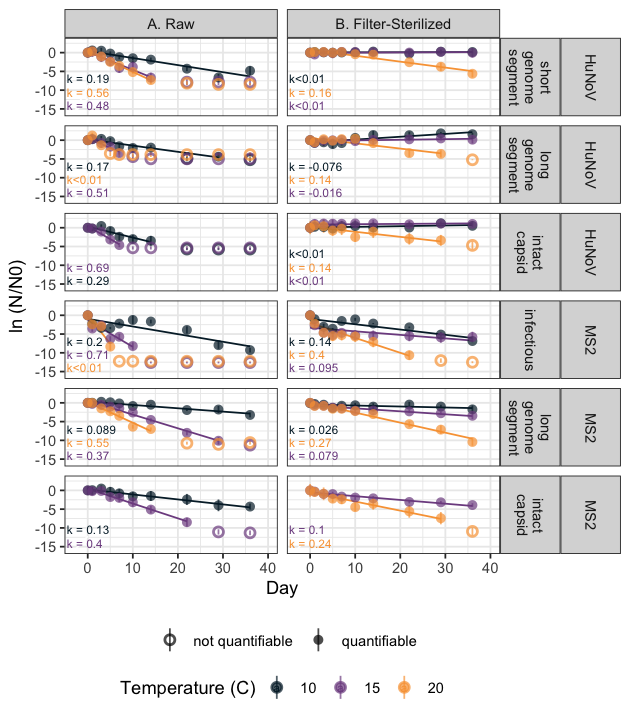

In [35]:
b=6
options(repr.plot.width =b*((half.col_w)/(max_h/1.5)), repr.plot.height = b) #change the size of the plot

a<-df_group
a[a$filtered=="U","filtered"]<-"A. Raw"
a[a$filtered=="F","filtered"]<-"B. Filter-Sterilized"
a[(a$RNase_treated== "Y"), "assay"]<- "intact\ncapsid"
a$storage_condition<-factor(a$storage_condition)
a$bdl<-factor(a$bdl)

a$assay<-factor(a$assay, levels=c('infectious','short\ngenome\nsegment', 'long\ngenome\nsegment','intact\ncapsid'))

g<-ggplot(a, aes(x=day,color=storage_condition, shape=bdl))+
    geom_line(aes(y=fit), show.legend=FALSE)+
    geom_pointrange(aes(y=mean_lnNN0,ymin= mean_lnNN0 -std_lnNN0, ,ymax= mean_lnNN0 +std_lnNN0 ), size=0.5, alpha=0.7, stroke=1.2)+
    scale_color_manual(values=c(c10,c15,c20))+
    ylab("ln (N/N0)")+
    xlab("Day")+
    scale_shape_manual(values=c(1,16))+
    guides(col=guide_legend("Temperature (C)"),shape=guide_legend(""))+
    facet_grid(org+assay~filtered)+
    theme_bw()+
    ylim(-16,3)+
    xlim(-3,40)+ 
    theme(legend.position= "bottom", legend.box='vertical',legend.spacing.y = unit(0.01, 'cm'))

dfl<-unique(a[,c("k","assay","storage_condition","filtered","org")])
dfl$bdl<-"quantifiable"
dfl$k<-sprintf("%1.2g",dfl$k)
dfl<- dfl%>% 
mutate(Label=paste("k = ",k, sep=""))
dfl[dfl$k == 0.01, "Label"]<- "k<0.01"

g<-g + geom_text_repel(data=dfl,aes(x=-3,y=-16,label=Label),size=2.5, direction="y", segment.color = "transparent",seed=11, alpha=1,   box.padding=0.1)

ggsave(paste0(path_f,"Figure_1.jpg"),  units='mm',device= 'jpg',width=half.col_w, height=max_h/1.5)

g

### Figure 2

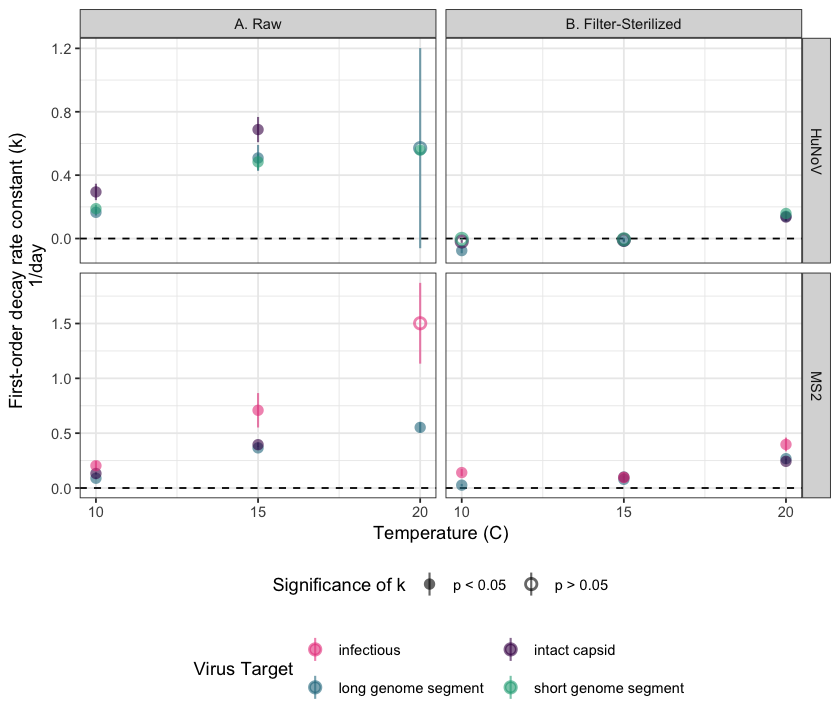

In [36]:
options(repr.plot.width =b*((half.col_w)/(max_h/2)), repr.plot.height = b) #change the size of the plot

a<-kobs
a[a$matrix=="R","matrix"]<-"A. Raw"
a[a$matrix=="F","matrix"]<-"B. Filter-Sterilized"

g<-ggplot(a, aes(x=temperature))+
    geom_hline(yintercept=0, linetype='dashed')+
    geom_pointrange(aes(y=k_plot,ymin=k_lwr,ymax= k_upr, shape=significance, color=assay ), size=0.6, alpha=0.6, stroke=1.2)+
    xlab("Temperature (C)")+
    ylab("First-order decay rate constant (k) \n 1/day")+
    scale_color_manual(values=c(cy,cl, cc,cs))+ 
    scale_shape_manual(values=c(16,1))+
    scale_x_continuous(breaks=c(0,5,10,15,20,25))+
    facet_grid(org~matrix, scales ="free_y")+
    guides(col=guide_legend("Virus Target",nrow=2, byrow=TRUE),shape=guide_legend("Significance of k"))+
    theme_bw()+
    theme(legend.position= "bottom", legend.box='vertical')

ggsave(paste0(path_f,"Figure_2.jpg"),  units='mm',device= 'jpg',width=half.col_w, height=max_h/2)

g

### Figure 3

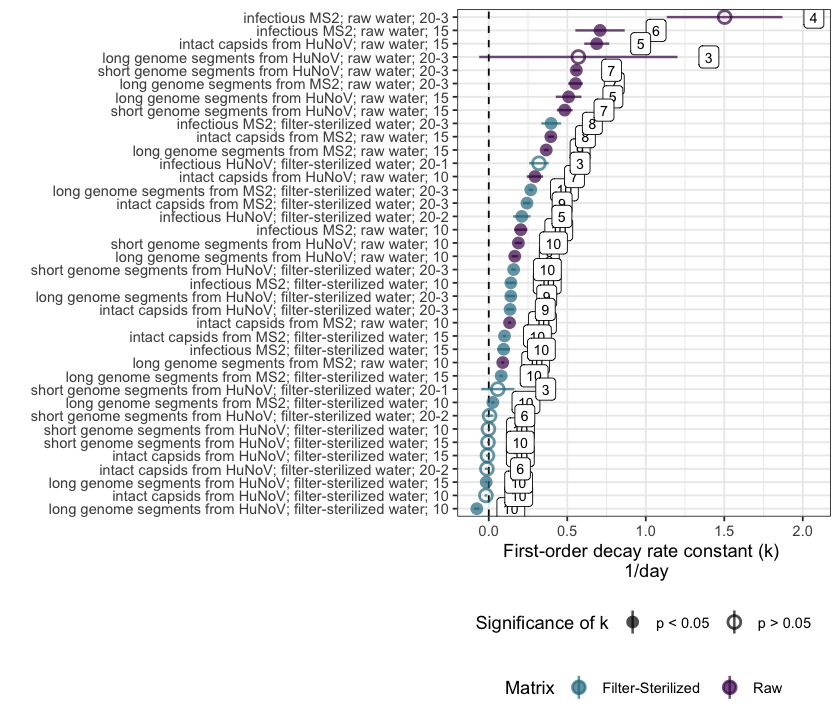

In [37]:
a<-kobs_full
a$temperature<-as.character(a$temperature)
a[a$matrix=="R","matrix"]<-"raw"
a[a$matrix=="0.22-F","matrix"]<-"filter-sterilized"
a[a$matrix=="0.1-F","matrix"]<-"filter-sterilized"
a[a$temperature=="10","temperature"]<-"10C"
a[a$temperature=="15","temperature"]<-"15C"
a[a$temperature=="20","temperature"]<-"20C"
a$temperature<-as.factor(a$temperature)
a[is.na(a$k_upr),"k_upr"]<- a[is.na(a$k_upr),"k_plot"]
a$assay<- gsub("genome segment", "genome segments from", a$assay)
a$assay<- gsub("intact capsid", "intact capsids from", a$assay)

a$id<-paste( a$assay, " ", a$org, "; ", a$matrix, " water; ",  a$experiment,  sep="")
a[a$matrix=="raw","matrix"]<-"Raw"
a[a$matrix=="filter-sterilized","matrix"]<-"Filter-Sterilized"


a$n=as.factor(a$n)
g<-ggplot(a, aes(y=reorder(id,k_plot)))+
    geom_vline(xintercept=0, linetype='dashed')+
    geom_pointrange(aes(x=k_plot,xmin=k_lwr,xmax= k_upr, shape=significance, color=matrix ), size=0.7, alpha=0.7, stroke=1.2)+
    geom_label(aes(x=k_upr+0.2,label=n, ), size=3)+
    ylab("")+
    xlab("First-order decay rate constant (k) \n 1/day")+
    scale_color_manual(values=c(cc,cl,cs))+ 
    scale_shape_manual(values=c(16,1))+
    guides(color=guide_legend("Matrix"),shape=guide_legend("Significance of k"))+
    theme_bw()+
    theme(legend.position= "bottom", legend.box='vertical')

ggsave(paste0(path_f,"Figure_3.jpg"),  units='mm',device= 'jpg',width=max_w, height=max_h)

g

### Figure S2

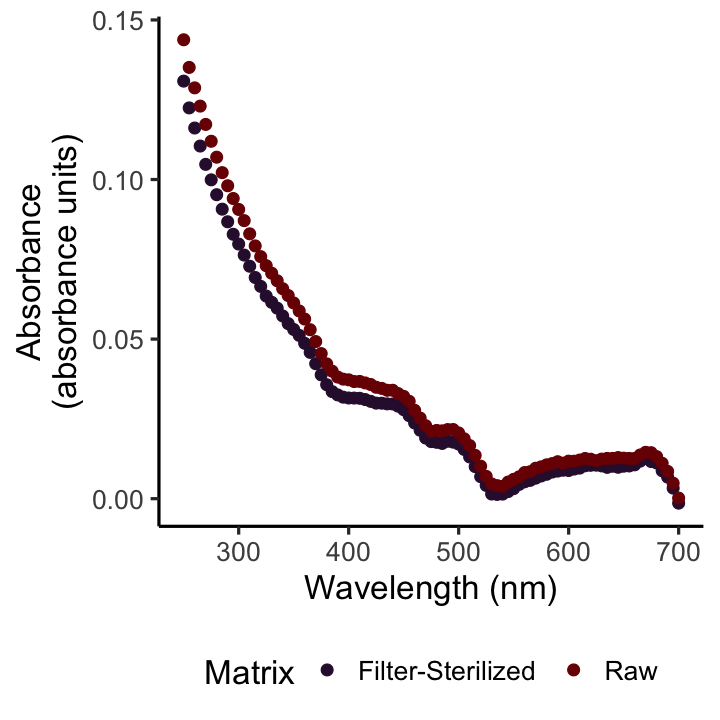

In [38]:
a<- absorbance[,c("Wavelength_nm", "San_Pedro_Creek_0.22um_F_abs")]
names(a)<- c("Wavelength_nm", "absorbance")
a$matrix=  "San_Pedro_Creek_0.22um_F_abs"

b<-absorbance[,c("Wavelength_nm", "San_Pedro_Creek_Raw_abs")]
names(b)<- c("Wavelength_nm", "absorbance")
b$matrix=  "San_Pedro_Creek_Raw_abs"

absorbance_l<-rbind(a,b)

options(repr.plot.width =6, repr.plot.height = 6) #change the size of the plot
theme_set(theme_classic(base_size=20))# set font size

a<-absorbance_l
a[a$matrix==  "San_Pedro_Creek_0.22um_F_abs", "matrix"]<-"Filter-Sterilized"
a[a$matrix==  "San_Pedro_Creek_Raw_abs", "matrix"]<-"Raw"

g<- ggplot(a, aes(x=Wavelength_nm, y=absorbance, color=matrix))+
    geom_point(size=3)+
    xlab("Wavelength (nm)")+
    ylab("Absorbance\n(absorbance units)")+
    guides(color=guide_legend("Matrix"))+
    scale_color_viridis_d(option='turbo')+
    theme(legend.position= "bottom")


ggsave(paste0(path_f,"Figure_S2.jpg"),  units='mm',device= 'jpg',width=half.col_w, height=max_h/2)

g


## 3. Mulltiple linear regression

### Table S8

In [39]:
#Equation #2: particles, temp, interaction -- huNoV

base<-df_group
base<-base[base$org == "HuNoV",]
base<-base[base$target == "ORF",]
base<-base[(base$RNase_treated == "N"),]
base<-base[base$bdl =="quantifiable",]
base$C<-base$storage_condition
base$C <- base$C -15
base$t<-base$day

base$F<- 0
base[base$filtered =="F", "F"]<-1

reg=lm(mean_lnNN0~t + F+ t:F+ C + t:C + F:C +t:F:C , data=base)

summary(reg)
out<-tidy(reg)
out<- as.data.frame(out)
stargazer(out,type="html", summary=FALSE, rownames=FALSE, digits=4, out=paste0(path_f,"Table_S8.doc"))




Call:
lm(formula = mean_lnNN0 ~ t + F + t:F + C + t:C + F:C + t:F:C, 
    data = base)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6345 -0.3201 -0.0186  0.4237  1.5864 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.300719   0.235707   1.276 0.208426    
t           -0.393242   0.028049 -14.020  < 2e-16 ***
F           -0.043757   0.308600  -0.142 0.887864    
C            0.023668   0.055014   0.430 0.669046    
t:F          0.342875   0.030314  11.311 7.02e-15 ***
t:C         -0.041966   0.005869  -7.150 5.43e-09 ***
F:C          0.047799   0.073533   0.650 0.518905    
t:F:C        0.025897   0.006510   3.978 0.000244 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.742 on 46 degrees of freedom
Multiple R-squared:  0.8962,	Adjusted R-squared:  0.8804 
F-statistic: 56.71 on 7 and 46 DF,  p-value: < 2.2e-16



<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">term</td><td>estimate</td><td>std.error</td><td>statistic</td><td>p.value</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">(Intercept)</td><td>0.3007</td><td>0.2357</td><td>1.2758</td><td>0.2084</td></tr>
<tr><td style="text-align:left">t</td><td>-0.3932</td><td>0.0280</td><td>-14.0198</td><td>0</td></tr>
<tr><td style="text-align:left">F</td><td>-0.0438</td><td>0.3086</td><td>-0.1418</td><td>0.8879</td></tr>
<tr><td style="text-align:left">C</td><td>0.0237</td><td>0.0550</td><td>0.4302</td><td>0.6690</td></tr>
<tr><td style="text-align:left">t:F</td><td>0.3429</td><td>0.0303</td><td>11.3107</td><td>0</td></tr>
<tr><td style="text-align:left">t:C</td><td>-0.0420</td><td>0.0059</td><td>-7.1500</td><td>0</td></tr>
<tr><td style="text-align:left">F:C</td><td>0.0478</td><td>0.0735</td><td>0.6500<

In [40]:
b1= out[out$term== "t","estimate"]
b12= out[out$term== "t:F","estimate"]
b13= out[out$term== "t:C","estimate"]
b123= out[out$term== "t:F:C","estimate"]

# Raw 20C
round(b1 +(b13*5),2)

# Raw 15C (reference)
round(b1,2)

# Filtered 20C
round(b1 + b12+(b13*5)+(b123*5),2)

# Filtered 15C
round(b1 + b12,2)

[1] -0.6

[1] -0.39

[1] -0.13

[1] -0.05

### Table S9

In [41]:
#Equation #2: particles, temp, interaction -- MS2

base<-df_group
base<-base[base$org == "MS2",]
base<-base[base$target == "Culture",]
base<-base[(base$RNase_treated == "N"),]
base<-base[base$bdl =="quantifiable",]
base$C<-base$storage_condition
base$C <- base$C -15
base$t<-base$day

base$F<- 0
base[base$filtered =="F", "F"]<-1

reg=lm(mean_lnNN0~t + F+ t:F+ C + t:C + F:C +t:F:C , data=base)

summary(reg)
out<-tidy(reg)
out<- as.data.frame(out)
stargazer(out,type="html", summary=FALSE, rownames=FALSE, digits=4, out=paste0(path_f,"Table_S9.doc"))




Call:
lm(formula = mean_lnNN0 ~ t + F + t:F + C + t:C + F:C + t:F:C, 
    data = base)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0803 -1.1283 -0.0636  0.8459  3.1678 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.76760    0.54697  -1.403  0.16822    
t           -0.79194    0.12488  -6.341 1.57e-07 ***
F           -1.56241    0.68654  -2.276  0.02829 *  
C            0.06265    0.11967   0.524  0.60347    
t:F          0.61676    0.12819   4.811 2.16e-05 ***
t:C         -0.11881    0.02500  -4.752 2.60e-05 ***
F:C         -0.23281    0.15799  -1.474  0.14843    
t:F:C        0.10388    0.02615   3.972  0.00029 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.498 on 40 degrees of freedom
Multiple R-squared:  0.7269,	Adjusted R-squared:  0.6791 
F-statistic: 15.21 on 7 and 40 DF,  p-value: 1.664e-09



<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">term</td><td>estimate</td><td>std.error</td><td>statistic</td><td>p.value</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">(Intercept)</td><td>-0.7676</td><td>0.5470</td><td>-1.4034</td><td>0.1682</td></tr>
<tr><td style="text-align:left">t</td><td>-0.7919</td><td>0.1249</td><td>-6.3415</td><td>0.000000</td></tr>
<tr><td style="text-align:left">F</td><td>-1.5624</td><td>0.6865</td><td>-2.2758</td><td>0.0283</td></tr>
<tr><td style="text-align:left">C</td><td>0.0627</td><td>0.1197</td><td>0.5236</td><td>0.6035</td></tr>
<tr><td style="text-align:left">t:F</td><td>0.6168</td><td>0.1282</td><td>4.8114</td><td>0.00002</td></tr>
<tr><td style="text-align:left">t:C</td><td>-0.1188</td><td>0.0250</td><td>-4.7524</td><td>0.00003</td></tr>
<tr><td style="text-align:left">F:C</td><td>-0.2328</td><td>0.

In [42]:
b1= out[out$term== "t","estimate"]
b12= out[out$term== "t:F","estimate"]
b13= out[out$term== "t:C","estimate"]
b123= out[out$term== "t:F:C","estimate"]

# Raw 20C
round(b1 +(b13*5),2)

# Raw 15C (reference)
round(b1,2)

# Filtered 20C
round(b1 + b12+(b13*5)+(b123*5),2)

# Filtered 15C
round(b1 + b12,2)

[1] -1.39

[1] -0.79

[1] -0.25

[1] -0.18

### Table S10

In [43]:
#Equation #3: targets -- huNoV

base<-df_group
base<-base[base$org == "HuNoV",]
base<-base[(base$storage_condition ==15),]#condition for which all data is present (i.e., intact capsids) also base case above
base<-base[base$bdl =="quantifiable",]
base$t<-base$day

base$I<- 0
base[base$RNase_treated =="Y", "I"]<-1
base$L<- 0
base[base$target =="NR1", "L"]<-1
base$F<- 0
base[base$filtered =="F", "F"]<-1

reg=lm(mean_lnNN0~t +F+ t:F +L + t:L + I + t:I  , data=base)

summary(reg)
out<-tidy(reg)
out<- as.data.frame(out)
stargazer(out,type="html", summary=FALSE, rownames=FALSE, digits=4, out=paste0(path_f,"Table_S10.doc"))


Call:
lm(formula = mean_lnNN0 ~ t + F + t:F + L + t:L + I + t:I, data = base)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.60467 -0.18789 -0.04313  0.25299  1.09795 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.175324   0.253560   0.691    0.493    
t           -0.506608   0.036313 -13.951   <2e-16 ***
F           -0.025938   0.244358  -0.106    0.916    
L           -0.040298   0.261834  -0.154    0.878    
I            0.232191   0.263284   0.882    0.383    
t:F          0.507203   0.036307  13.970   <2e-16 ***
t:L          0.003791   0.018333   0.207    0.837    
t:I          0.020326   0.018359   1.107    0.275    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5387 on 39 degrees of freedom
Multiple R-squared:  0.9133,	Adjusted R-squared:  0.8978 
F-statistic: 58.71 on 7 and 39 DF,  p-value: < 2.2e-16



<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">term</td><td>estimate</td><td>std.error</td><td>statistic</td><td>p.value</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">(Intercept)</td><td>0.1753</td><td>0.2536</td><td>0.6915</td><td>0.4934</td></tr>
<tr><td style="text-align:left">t</td><td>-0.5066</td><td>0.0363</td><td>-13.9510</td><td>0</td></tr>
<tr><td style="text-align:left">F</td><td>-0.0259</td><td>0.2444</td><td>-0.1061</td><td>0.9160</td></tr>
<tr><td style="text-align:left">L</td><td>-0.0403</td><td>0.2618</td><td>-0.1539</td><td>0.8785</td></tr>
<tr><td style="text-align:left">I</td><td>0.2322</td><td>0.2633</td><td>0.8819</td><td>0.3832</td></tr>
<tr><td style="text-align:left">t:F</td><td>0.5072</td><td>0.0363</td><td>13.9698</td><td>0</td></tr>
<tr><td style="text-align:left">t:L</td><td>0.0038</td><td>0.0183</td><td>0.20

### Table S11

In [44]:
#Equation #3: targets -- MS2

base<-df_group
base<-base[base$org == "MS2",]
base<-base[(base$storage_condition ==15),]#condition for which all data is present (i.e., intact capsids) also base case above
base<-base[base$bdl =="quantifiable",]
base$t<-base$day

base$I<- 0
base[base$RNase_treated =="Y", "I"]<-1
base$L<- 0
base[base$target =="MP1", "L"]<-1
base$F<- 0
base[base$filtered =="F", "F"]<-1

reg=lm(mean_lnNN0~t + F+ t:F+ L + t:L + I + t:I  , data=base)

summary(reg)
out<-tidy(reg)
out<- as.data.frame(out)
stargazer(out,type="html", summary=FALSE, rownames=FALSE, digits=4, out=paste0(path_f,"Table_S11.doc"))



Call:
lm(formula = mean_lnNN0 ~ t + F + t:F + L + t:L + I + t:I, data = base)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9095 -0.4115 -0.0759  0.3485  3.4175 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.37323    0.37613  -6.310 1.08e-07 ***
t           -0.40362    0.03460 -11.665 3.36e-15 ***
F           -1.04425    0.36781  -2.839  0.00677 ** 
L            2.84947    0.43729   6.516 5.33e-08 ***
I            0.01785    0.43613   0.041  0.96754    
t:F          0.30318    0.02977  10.183 2.93e-13 ***
t:L          0.02532    0.03040   0.833  0.40923    
t:I         -0.02354    0.02905  -0.810  0.42196    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9153 on 45 degrees of freedom
Multiple R-squared:  0.8869,	Adjusted R-squared:  0.8693 
F-statistic: 50.42 on 7 and 45 DF,  p-value: < 2.2e-16



<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">term</td><td>estimate</td><td>std.error</td><td>statistic</td><td>p.value</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">(Intercept)</td><td>-2.3732</td><td>0.3761</td><td>-6.3097</td><td>0.000000</td></tr>
<tr><td style="text-align:left">t</td><td>-0.4036</td><td>0.0346</td><td>-11.6655</td><td>0</td></tr>
<tr><td style="text-align:left">F</td><td>-1.0443</td><td>0.3678</td><td>-2.8391</td><td>0.0068</td></tr>
<tr><td style="text-align:left">L</td><td>2.8495</td><td>0.4373</td><td>6.5161</td><td>0.000000</td></tr>
<tr><td style="text-align:left">I</td><td>0.0178</td><td>0.4361</td><td>0.0409</td><td>0.9675</td></tr>
<tr><td style="text-align:left">t:F</td><td>0.3032</td><td>0.0298</td><td>10.1834</td><td>0</td></tr>
<tr><td style="text-align:left">t:L</td><td>0.0253</td><td>0.0304</td><td>